In [1]:
#Importing the required packages and methods to implement the KNN model for Yelp review Classification
#Importing PorterStemmer for stemming the text data to replace root words
from nltk.stem.porter import PorterStemmer

# importing pyplot from matplotlib for graph for better K value to build KNN algorithm
from matplotlib import pyplot as plt

#Loading TfidfVectorizer that converts text into vector by transforming into sparse matrix
from sklearn.feature_extraction.text import TfidfVectorizer

#From sklearn metrics, imported cosine similarity to find the similarities of 2 sparse matrix
from sklearn.metrics.pairwise import cosine_similarity

#Loading the stopwords from nltk to remove stopwords from the train and text data
from nltk.corpus import stopwords

#importing the re to perform operation on data by regular expressions
import re

#Importing numpy package and defining a variable for package that used to perform operations on 2 D arrays
import numpy as np

#Loading the Pandas that use to perform operations on dataframe like loading loading .csv file and data operations
import pandas as pd

#sklearn is required here for K-fold cross validation.
import sklearn



# Preprocess the data
Removing the unwanted data like quotes, digits, special characters,1 letter and 2 letter words by using re.sub() method.

In [2]:
def Preprocess_the_data(data):
    
    #Converting the text into lower case
    data = data.lower()
    
    #Replacing the most common helping words and replacing the text in meaningful way
    remove_list = ['\\n','http\S+',"won't","can\'t","n\'t","\'d","\'ve","\'re","\'s","\'ll","\'m",'youll']
    replaced_data = [' ',' ','will not','can not',' not',' would',' have',' are',' is',' will',' am','you will']

    #Creating the loop to remove and replace the text in data
    for i in range(len(remove_list)):
        data = data.replace(remove_list[i], replaced_data[i])
    
    #substituting the 1 and 2 letter words with space
    data=re.sub(r'\b\w{1,2}\b', ' ', data)

    return data.strip()

# Porter stemmer
Removing the stopwords from text data

In [3]:
def Porter_Stemmer(review):
    
    #Loading the PorterStemmer function and creating object for it
    ps = PorterStemmer()
    
    #converting into list for further preprocessing 
    result = list(review.split(" "))
    text =[]
    
    #Appending all the text words except stopwords
    stopword = stopwords.words("english")
    for word in result:
        if (word not in stopword):
            text.append(ps.stem(word))
            
    #Converting list into string with join function
    text = ' '.join(text)
    
    #strip helps to remove extra spaces
    return text.strip()

# Loading train data 
Calling the required functions for preprocess and stemming the text data

In [7]:
def train_csv():
    
    #Loading the .csv file read_csv function through pandas pd
    df = pd.read_csv('1662145253_9967718_new_train.csv',header=None)
    
    #performing basic operations by dropping NA values and reset the index
    df = df.dropna()
    df = df.reset_index(drop=True)
    
    #Naming the 2 columns with label and review names
    df.columns =['label','review']
    
    df1 = df
    # plot the word count before preprocess
    plt.figure(figsize=(9,4))
    
    df1['wordcount_before_preprocess']=df['review'].apply(lambda y: len(str(y).split()))
    rev=df1['wordcount_before_preprocess'].plot()
    
    #calling preprocess function for review column for each row
    df['review'] = df['review'].apply(lambda x: Preprocess_the_data(x))

    #Calling Porterstemmer function for each row of review column
    df['review'] = df['review'].apply(lambda x: Porter_Stemmer(x))
    
    df1['word_count_after_preprocess']=df['review'].apply(lambda y: len(str(y).split()))
    pre_rev=df1['word_count_after_preprocess'].plot()
    
    plt.title('Frequency of words in the text of yelp classification reviews before and after preprocessing the text')
    plt.ylabel('Frequency of Words')
    plt.xlabel('Review words')
    plt.legend()

    
    #Creating vectorizer with TfidfVectorizer function and performing fit transform function to X( df['review'])
    tf_vectorizer = TfidfVectorizer(max_features = 5000)
    tfidf=tf_vectorizer.fit_transform(df['review'])
    
    #Return TfidfVectorizer object and train sparse matrix and train data 
    return tf_vectorizer,tfidf,df

# Prediction function
Finding nearest review of yelp review

In [8]:
def new_Prediction(nearest_reviews,df):
    
    #initializing positive and negative values with 0 
    Prediction_values =[]

    #Appending the positive and negative values to test data 
    for k in nearest_reviews:
        
        Prediction_values.append(df[k])
        
    #Check max of positive and negative values  
    genLab = max(Prediction_values,key=Prediction_values.count)

    return genLab

# KNN function 
To find nearest vectors of the test data with train data(reviews)

In [9]:
def KNN(train,test):
    
    #Finding the cosine similarity of train and test data
    cs = cosine_similarity(train,test)
    
    #Transpose the cs to rows to columns
    cs = cs.T

    #Finding the nearest index using argsort function
    nearest_values = np.argsort(cs,axis = 1)
    
    #returning the nearest values
    return nearest_values

# Loading the train data

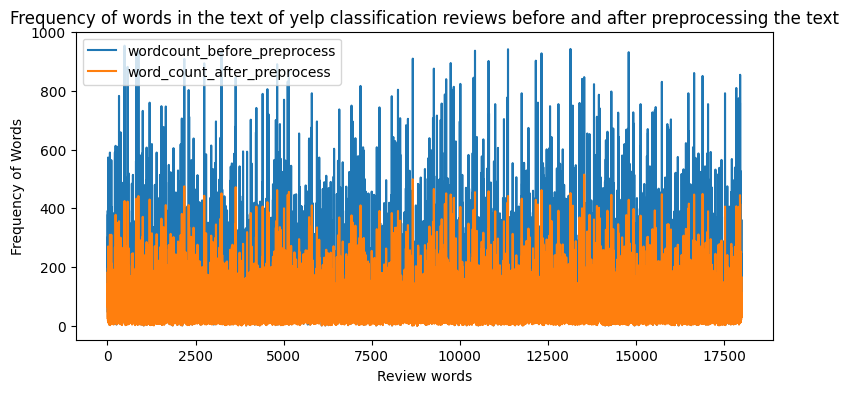

In [10]:
#Function returns TfidfVectorizer object and train sparse matrix and train data frame
tf_vectorizer,train_tfidf,train_df = train_csv()

In [12]:
#Creating y label as array
y = train_df['label'].values

# K-fold Cross Validation


In [13]:
K_folds = sklearn.model_selection.KFold(n_splits=5, shuffle=True)

# To choose best K value

In [15]:
#Creating empty list for accuracy, k values, and root mean square error
accuracy_list = []
k_values = []
avg_acc = []
rmse_list =[]

for k in range(21,90,2):
    
    #initial mean average of accuracy with 0
    mean_ls=0
    
    #K_fold split with 5 folds
    for train, test in K_folds.split(train_tfidf):

        X_train = train_tfidf[train]
        X_test = train_tfidf[test]
        y_train = y[train]
        y_test = y[test]
        
        #finding the nearest reivews with KNN function as KNN algorithm
        nearest_values = KNN(X_train,X_test)
        
        #Initialize the list of prediction with list
        list_of_predictions=[]

        # Finding the new predictions for test data
        for i in range(X_test.shape[0]):
            cosine_row = nearest_values[i]
            cosine_row = cosine_row[-k:]
            new_label = new_Prediction(cosine_row,y_train)
            list_of_predictions.append(new_label)

        #calculating the accuracy score with metrics
        acc=sklearn.metrics.accuracy_score(y_test, list_of_predictions,normalize=True, sample_weight=None)
        mean_ls+=(acc)
    
    avg_acc = mean_ls/5
    avg_acc = round(avg_acc,3)
    
    print(avg_acc,k)
    
    #Appending all the accuracy and k values for reference and to build graph and choose best K value to build KNN alforithm
    accuracy_list.append(avg_acc*100)
    k_values.append(k)

0.792 21
0.794 23
0.791 25
0.797 27
0.798 29
0.796 31
0.799 33
0.801 35
0.803 37
0.801 39
0.801 41
0.801 43
0.804 45
0.805 47
0.805 49
0.805 51
0.805 53
0.807 55
0.806 57
0.803 59
0.808 61
0.808 63
0.809 65
0.805 67
0.808 69
0.808 71
0.806 73
0.809 75
0.81 77
0.809 79
0.809 81
0.81 83
0.81 85
0.809 87
0.811 89


In [33]:
accuracy_list = [0.792,0.794,
0.791,
0.797,
0.798,
0.796,
0.799,
0.801,
0.803,
0.801,
0.801,
0.801,
0.804,
0.805,
0.805,
0.805,
0.805,
0.805,
0.806,
0.805,
0.808,0.808,
0.809,
0.805,
0.806,
0.807,
0.807,
0.808,
0.808,
0.808,
0.808,
0.808,
0.808,
0.808,
0.808]

Text(0, 0.5, 'Accuracy')

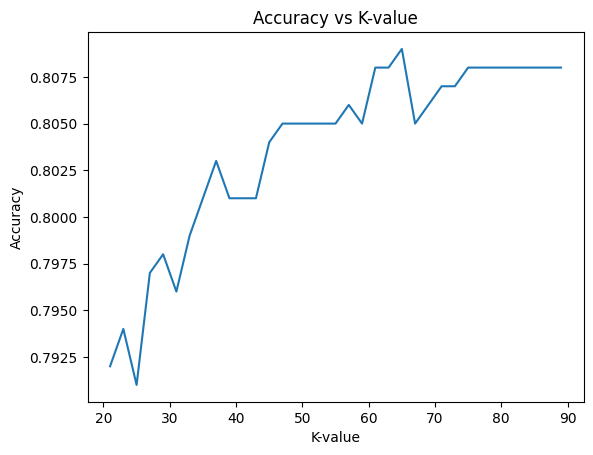

In [34]:
#plot the graph of K values and accuracy of it
plt.plot(k_values, accuracy_list)
plt.title('Accuracy vs K-value')
plt.xlabel("K-value")
plt.ylabel("Accuracy")


In [35]:
def test_csv(tf_vectorizer):
    
    df = pd.read_csv('1662145254_0395114_new_test.csv',header = None)
    
    df.columns =['review']
    
    df = df.dropna()
    df = df.reset_index(drop=True)
    
    #calling preprocess function for review column for each row
    df['review'] = df['review'].apply(lambda x: Preprocess_the_data(x))

    #Calling Porterstemmer function for each row of review column
    df['review'] = df['review'].apply(lambda x: Porter_Stemmer(x))
    
    tfidf=tf_vectorizer.transform(df['review'])
    
    return tfidf

In [36]:
test_tfidf = test_csv(tf_vectorizer)

In [37]:
nearest_values = KNN(X_train,test_tfidf)

list_of_predictions=[]
k = 77

f = open('result.txt','w')
for i in range(test_tfidf.shape[0]):
    cosine_row = nearest_values[i]
    cosine_row = cosine_row[-k:]
    new_label = new_Prediction(cosine_row,y_train)
    list_of_predictions.append(new_label)
    f.write(str(new_label)+"\n")
f.close()